In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install keras
!pip install tqdm
!pip install pillow
!pip install seaborn
!pip install matplotlib

In [ ]:
import os
import cv2
import keras
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow.keras
import tensorflow as tf
from keras import optimizers
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.calibration import calibration_curve
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB4
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

In [ ]:
dataset='/content/drive/MyDrive/new_projects/N_p11/Pneumonia_Datasets'

train_folder = os.path.join(dataset,"training")
test_folder = os.path.join(dataset,"validation")

In [ ]:
img_size = 128
categories = []
for i in os.listdir(train_folder):
    categories.append(i)
print(categories)

['Normal', 'PNEUMONIA']


In [ ]:
# Function to process data
def process_data(folder, categories, img_size):
    data = []
    class_counts = {category: 0 for category in categories}
    for c in categories:
        path = os.path.join(folder, c)
        class_num = categories.index(c)
        for img in tqdm(os.listdir(path), desc=f"Processing {c}"):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_resized = cv2.resize(img_array, (img_size, img_size))
                data.append([img_resized, class_num])
                class_counts[c] += 1
            except Exception as e:
                pass
        print(f"Class '{c}' has {class_counts[c]} images")
    return data, class_counts

In [ ]:
def process_and_print_data(folder, data_type, categories, img_size):
    """Process and print data information for training or validation data."""
    print(f"{data_type} Data:")
    data, class_counts = process_data(folder, categories, img_size)
    print(f"Total {data_type.lower()} data: {len(data)}\n")
    return data, class_counts

# Process and print training data
training_data, train_class_counts = process_and_print_data(train_folder, "Training", categories, img_size)

# Process and print validation data
validation_data, val_class_counts = process_and_print_data(test_folder, "Validation", categories, img_size)


Training Data:


Processing Normal: 100%|██████████| 3674/3674 [03:29<00:00, 17.52it/s]


Class 'Normal' has 3674 images


Processing PNEUMONIA: 100%|██████████| 3600/3600 [02:37<00:00, 22.93it/s]


Class 'PNEUMONIA' has 3600 images
Total training data: 7274

Validation Data:


Processing Normal: 100%|██████████| 900/900 [00:42<00:00, 21.40it/s]


Class 'Normal' has 900 images


Processing PNEUMONIA: 100%|██████████| 910/910 [00:31<00:00, 28.76it/s]

Class 'PNEUMONIA' has 910 images
Total validation data: 1810



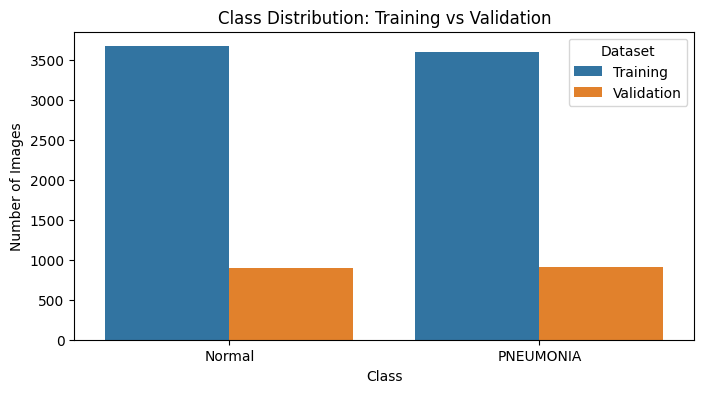

In [ ]:
def plot_combined_class_distribution(train_counts, val_counts, categories):
    """
    Plots a combined bar chart of class distributions for both training and validation data.
    """
    # Create a DataFrame for better visualization
    df = pd.DataFrame({
        'Category': categories,
        'Training': [train_counts[c] for c in categories],
        'Validation': [val_counts[c] for c in categories]
    })

    # Melt the DataFrame for seaborn compatibility
    df_melted = df.melt(id_vars='Category', var_name='Dataset', value_name='Count')

    # Plot the combined bar chart
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Category', y='Count', hue='Dataset', data=df_melted)
    plt.title('Class Distribution: Training vs Validation')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=0)
    plt.legend(title='Dataset')
    plt.show()
plot_combined_class_distribution(train_class_counts, val_class_counts, categories)


In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, img_size, img_size, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (7274, 128, 128, 3) Y_train= (7274,)


In [ ]:
X_test = []
Y_test = []

for features,label in validation_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, img_size, img_size, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (1810, 128, 128, 3) Y_test= (1810,)


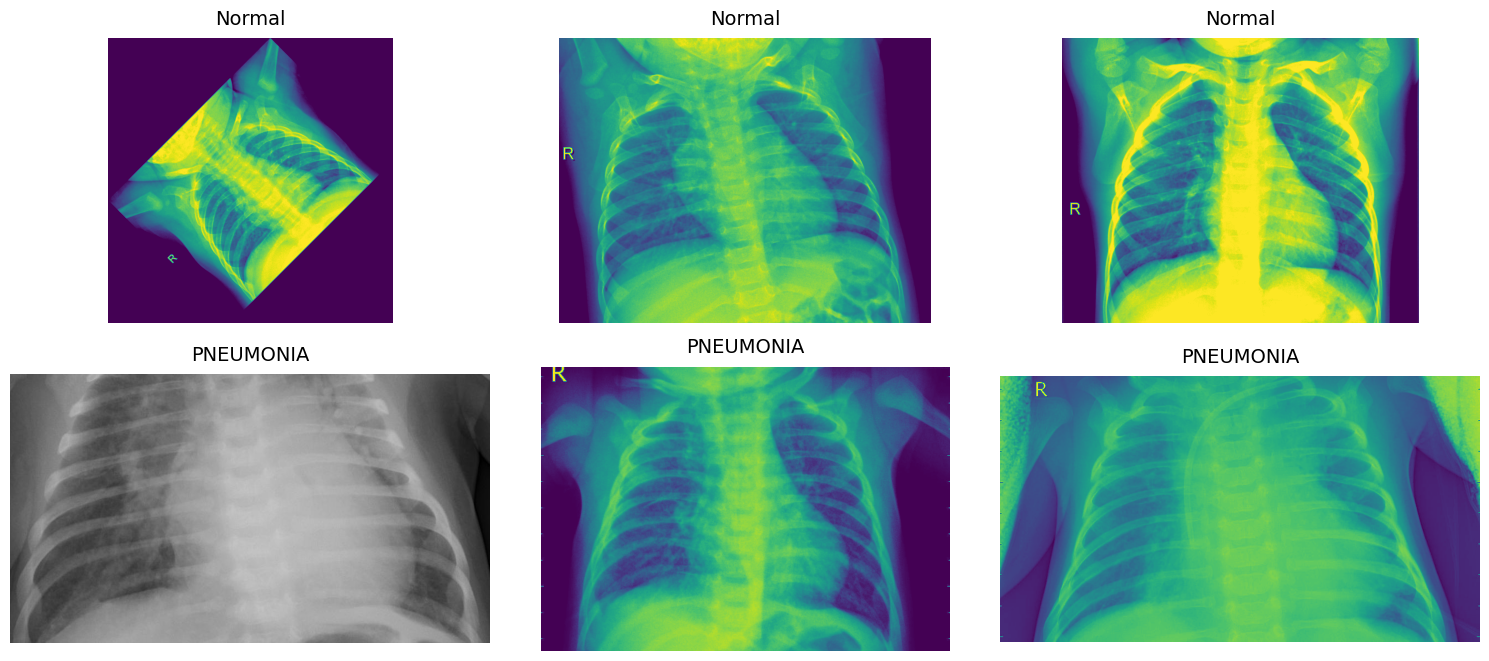

In [ ]:
images = []

for img_folder in sorted(os.listdir(train_folder)):
    img_items = os.listdir(os.path.join(train_folder, img_folder))

    # Randomly select 3 images from each class
    img_selected = np.random.choice(img_items, size=3, replace=False)

    for img in img_selected:
        images.append(os.path.join(train_folder, img_folder, img))

fig = plt.figure(1, figsize=(15, 10))

for subplot, image_ in enumerate(images):
    category = image_.split('/')[-2]
    imgs = plt.imread(image_)
    ax = fig.add_subplot(3, 3, subplot + 1)
    ax.set_title(category, pad=10, size=14)
    ax.imshow(imgs)
    ax.axis('off')

plt.tight_layout()


In [ ]:
input_shape = (128, 128, 3)

# Load MobileNet with pre-trained weights, specifying the input shape and without the top classification layers
mobilenet_base = EfficientNetB4(input_shape=input_shape, include_top=False, weights='imagenet')

# Add Global Average Pooling to reduce dimensionality
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Reduced dropout
x = Dense(96, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

# Add the final Dense layer for binary classification
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

# Create the final model
model = Model(inputs=mobilenet_base.input, outputs=output_layer)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 48)     │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 48)     │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 48)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 48)     │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 48)     │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 48)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 17,846,048 (68.08 MB)

 Trainable params: 17,720,841 (67.60 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using early stopping
model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          epochs=100,
          batch_size=32,
          callbacks=[early_stopping])

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 350s 754ms/step - accuracy: 0.9068 - loss: 1.3863 - val_accuracy: 0.5028 - val_loss: 0.8973
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 34s 147ms/step - accuracy: 0.9709 - loss: 0.2222 - val_accuracy: 0.5028 - val_loss: 1.5119
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9831 - loss: 0.0919 - val_accuracy: 0.9464 - val_loss: 0.1782
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.9866 - loss: 0.0732 - val_accuracy: 0.9740 - val_loss: 0.0992
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.9904 - loss: 0.0485 - val_accuracy: 0.9746 - val_loss: 0.0968
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.9956 - loss: 0.0392 - val_accuracy: 0.9685 - val_loss: 0.1414
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.9958 - loss: 0.0319 - val_accuracy: 0.9818 - val_loss: 0.0875
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9965 

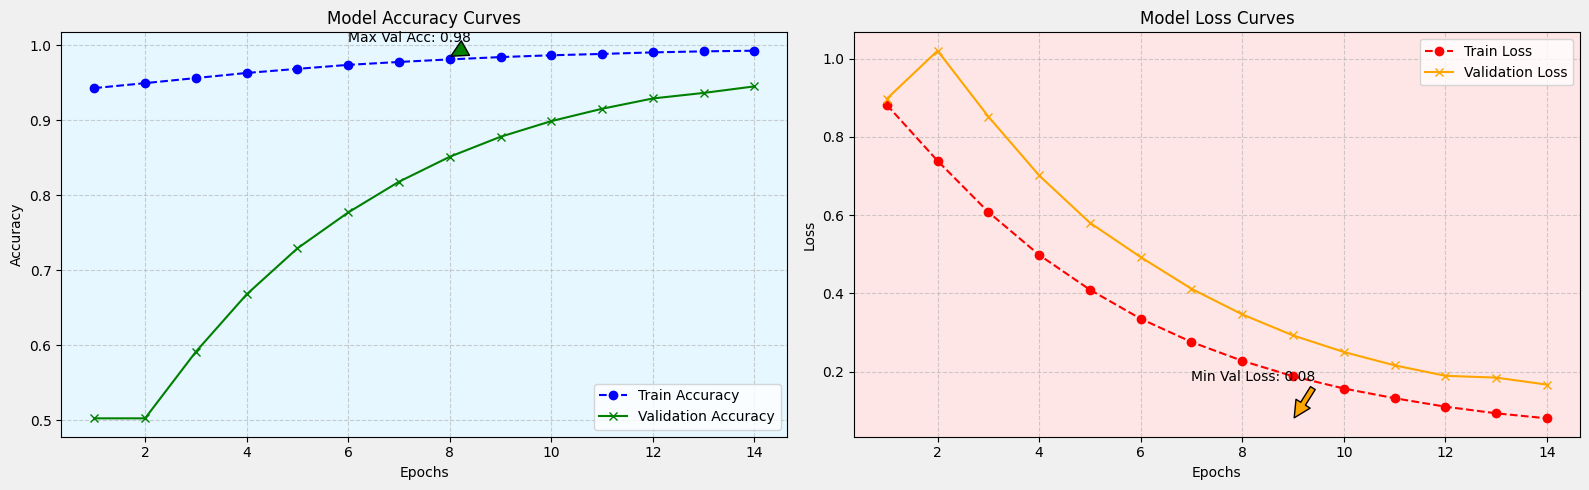

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Fetch history data
history = model.history.history
epochs = range(1, len(history['accuracy']) + 1)

# Create the figure
fig = plt.figure(figsize=(16, 5))

# Set the background color for the entire figure
fig.patch.set_facecolor('#f0f0f0')

# Plot 1: Accuracy Curves
plt.subplot(1, 2, 1)
train_acc = smooth_curve(history['accuracy'])
val_acc = smooth_curve(history['val_accuracy'])
plt.plot(epochs, train_acc, label='Train Accuracy', color='b', marker='o', linestyle='--')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='g', marker='x', linestyle='-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Set background color for the axis
ax = plt.gca()
ax.set_facecolor('#e6f7ff')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Highlight the maximum validation accuracy
max_val_acc = max(history['val_accuracy'])
max_epoch = np.argmax(history['val_accuracy']) + 1
plt.annotate(f'Max Val Acc: {max_val_acc:.2f}',
             xy=(max_epoch, max_val_acc),
             xytext=(max_epoch - 2, max_val_acc + 0.02),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=10)
plt.title(f'Model Accuracy Curves')

# Plot 2: Loss Curves
plt.subplot(1, 2, 2)
train_loss = smooth_curve(history['loss'])
val_loss = smooth_curve(history['val_loss'])
plt.plot(epochs, train_loss, label='Train Loss', color='r', marker='o', linestyle='--')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='x', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Set background color for the second axis
ax = plt.gca()
ax.set_facecolor('#ffe6e6')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Highlight the minimum validation loss
min_val_loss = min(history['val_loss'])
min_loss_epoch = np.argmin(history['val_loss']) + 1
plt.annotate(f'Min Val Loss: {min_val_loss:.2f}',
             xy=(min_loss_epoch, min_val_loss),
             xytext=(min_loss_epoch - 2, min_val_loss + 0.1),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=10)
plt.title(f'Model Loss Curves')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step


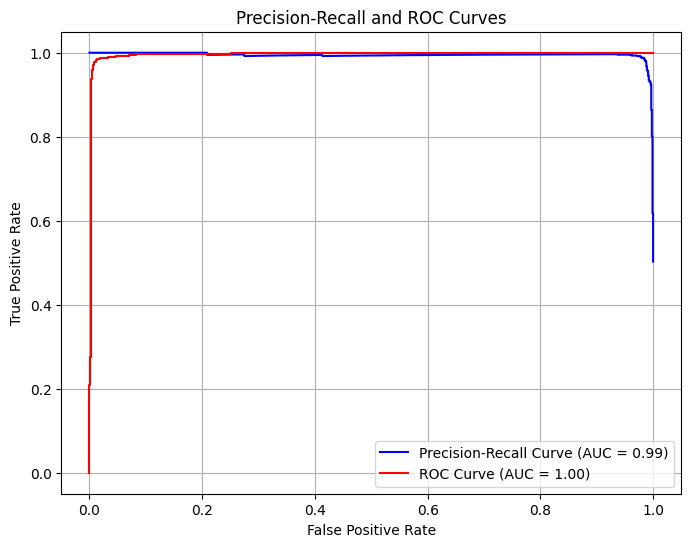

In [ ]:
Y_pred = model.predict(X_test)
precision, recall, _ = precision_recall_curve(Y_test, Y_pred)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Calculate AUC for both PR and ROC curves
pr_auc = auc(recall, precision)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the Precision-Recall curve
plt.plot(recall, precision, color='b', label='Precision-Recall Curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')

# Plot the ROC curve
plt.plot(fpr, tpr, color='r', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Precision-Recall and ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

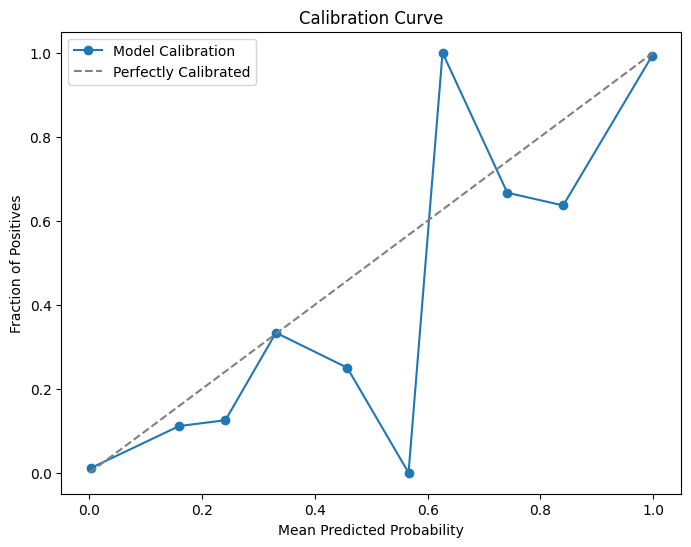

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(Y_test, Y_pred, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9856 - loss: 0.0689
228/228 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9989 - loss: 0.0213

Validation Accuracy: 0.9845303893089294

Validation Loss: 0.0771988034248352

Train Accuracy: 0.9990376830101013

Train Loss: 0.020190749317407608


In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

# Print the accuracy
print(f"Model Accuracy: {accuracy * 100:.2f}%")


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9856 - loss: 0.0689
Model Accuracy: 98.45%


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       900
           1       0.98      0.98      0.98       910

    accuracy                           0.98      1810
   macro avg       0.98      0.98      0.98      1810
weighted avg       0.98      0.98      0.98      1810



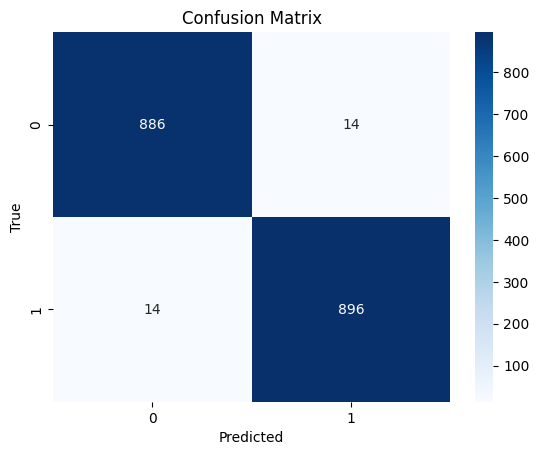

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.round(Y_pred)

# Generate classification report
print("\n Classification Report:\n")
report = classification_report(Y_test, Y_pred_classes)
print(report)

# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **Inceptionv3**

In [ ]:
num_classes = len(categories)

# Load the InceptionV3 model with pretrained weights from ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for binary classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model
Inceptionv3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
Inceptionv3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
Inceptionv3.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,903,010 (91.18 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
checkpoint = ModelCheckpoint('best_model_inceptionv3.keras', monitor='val_loss', save_best_only=True, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history = Inceptionv3.fit(X_train, Y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[checkpoint, early_stopping])


Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8297 - loss: 0.5720
Epoch 1: val_loss improved from inf to 0.20217, saving model to best_model_inceptionv3.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 61s 148ms/step - accuracy: 0.8299 - loss: 0.5713 - val_accuracy: 0.9320 - val_loss: 0.2022
Epoch 2/100
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9131 - loss: 0.2260
Epoch 2: val_loss improved from 0.20217 to 0.17437, saving model to best_model_inceptionv3.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 72ms/step - accuracy: 0.9132 - loss: 0.2259 - val_accuracy: 0.9403 - val_loss: 0.1744
Epoch 3/100
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9351 - loss: 0.1696
Epoch 3: val_loss did not improve from 0.17437
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9351 - loss: 0.1696 - val_accuracy: 0.9304 - val_loss: 0.1956
Epoch 4/100
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9452 - loss: 0.1480
Epoch 4: val_loss did not improve from 0.17437
228/22

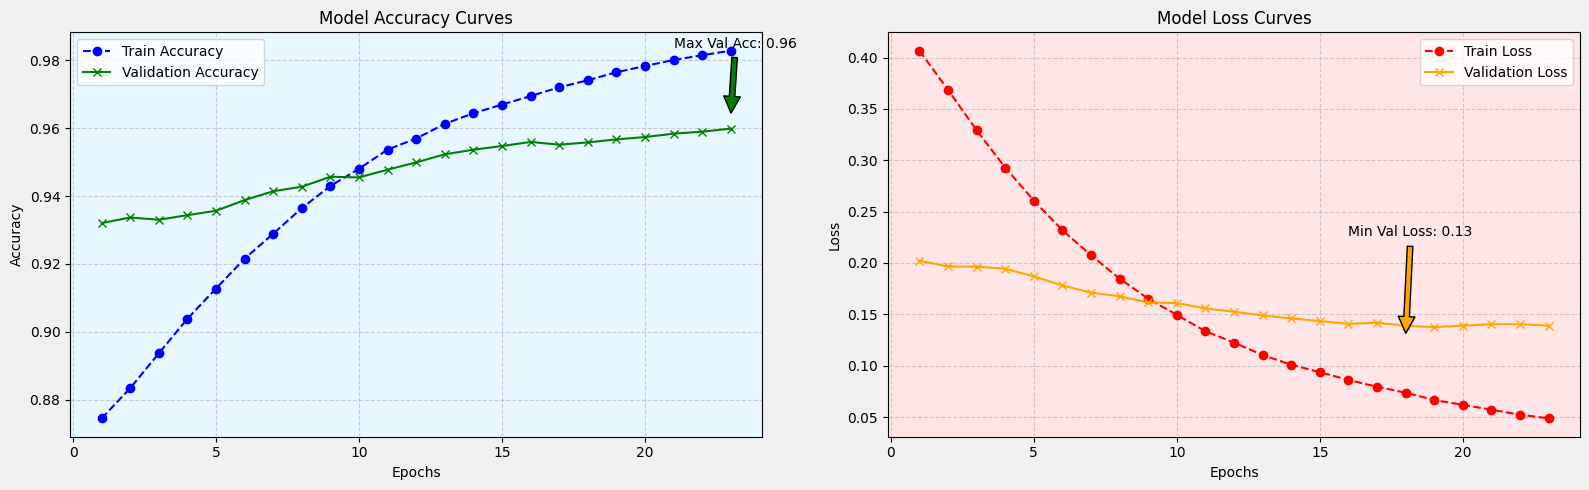

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Fetch history data
history = Inceptionv3.history.history
epochs = range(1, len(history['accuracy']) + 1)

# Create the figure
fig = plt.figure(figsize=(16, 5))

# Set the background color for the entire figure
fig.patch.set_facecolor('#f0f0f0')

# Plot 1: Accuracy Curves
plt.subplot(1, 2, 1)
train_acc = smooth_curve(history['accuracy'])
val_acc = smooth_curve(history['val_accuracy'])
plt.plot(epochs, train_acc, label='Train Accuracy', color='b', marker='o', linestyle='--')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='g', marker='x', linestyle='-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Set background color for the axis
ax = plt.gca()
ax.set_facecolor('#e6f7ff')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Highlight the maximum validation accuracy
max_val_acc = max(history['val_accuracy'])
max_epoch = np.argmax(history['val_accuracy']) + 1
plt.annotate(f'Max Val Acc: {max_val_acc:.2f}',
             xy=(max_epoch, max_val_acc),
             xytext=(max_epoch - 2, max_val_acc + 0.02),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=10)
plt.title(f'Model Accuracy Curves')

# Plot 2: Loss Curves
plt.subplot(1, 2, 2)
train_loss = smooth_curve(history['loss'])
val_loss = smooth_curve(history['val_loss'])
plt.plot(epochs, train_loss, label='Train Loss', color='r', marker='o', linestyle='--')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='x', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Set background color for the second axis
ax = plt.gca()
ax.set_facecolor('#ffe6e6')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Highlight the minimum validation loss
min_val_loss = min(history['val_loss'])
min_loss_epoch = np.argmin(history['val_loss']) + 1
plt.annotate(f'Min Val Loss: {min_val_loss:.2f}',
             xy=(min_loss_epoch, min_val_loss),
             xytext=(min_loss_epoch - 2, min_val_loss + 0.1),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=10)
plt.title(f'Model Loss Curves')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step


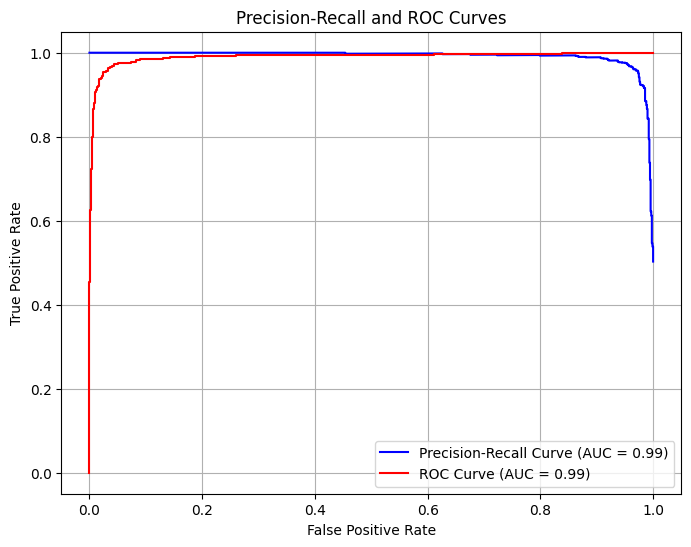

In [ ]:
Y_pred = Inceptionv3.predict(X_test)
# Select the probabilities for the positive class
precision, recall, _ = precision_recall_curve(Y_test, Y_pred[:, 1])
fpr, tpr, _ = roc_curve(Y_test, Y_pred[:, 1])

# Calculate AUC for both PR and ROC curves
pr_auc = auc(recall, precision)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the Precision-Recall curve
plt.plot(recall, precision, color='b', label='Precision-Recall Curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')

# Plot the ROC curve
plt.plot(fpr, tpr, color='r', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Precision-Recall and ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

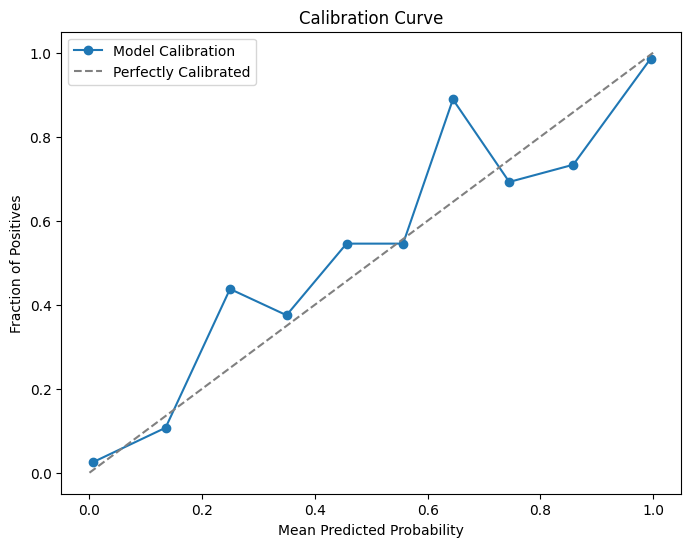

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(Y_test, Y_pred[:, 1], n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
valid_loss, valid_acc = Inceptionv3.evaluate(X_test, Y_test)
train_loss, train_acc = Inceptionv3.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9706 - loss: 0.0957
228/228 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9984 - loss: 0.0105

Validation Accuracy: 0.9635359048843384

Validation Loss: 0.13370291888713837

Train Accuracy: 0.9978004097938538

Train Loss: 0.012228606268763542


In [ ]:
loss, accuracy = Inceptionv3.evaluate(X_test, Y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9706 - loss: 0.0957
Accuracy: 96.35%


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       900
           1       0.97      0.96      0.96       910

    accuracy                           0.96      1810
   macro avg       0.96      0.96      0.96      1810
weighted avg       0.96      0.96      0.96      1810



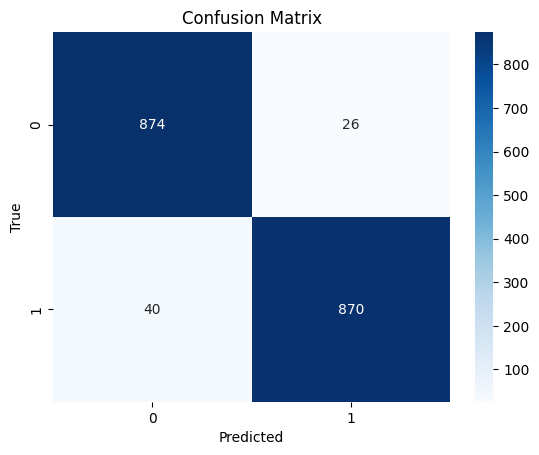

In [ ]:
Y_pred = Inceptionv3.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Generate classification report
print("\n Classification Report:\n")
report = classification_report(Y_test, Y_pred_classes)
print(report)

# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **Inference**

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('best_model_inceptionv3.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


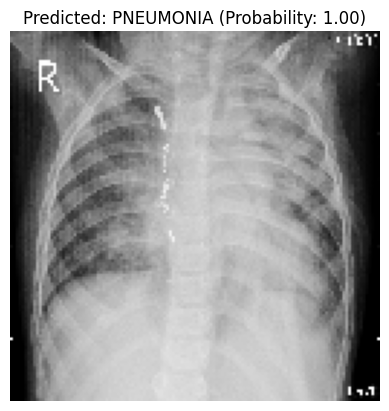

In [ ]:
def predict_image(image_path, model, img_size, categories):
  """Predicts the class of a single image.

  Args:
    image_path: Path to the image file.
    model: The loaded Keras model.
    img_size: Size to resize the image to.
    categories: List of possible categories/classes.

  Returns:
    A tuple containing:
      - The predicted class label (string).
      - The predicted class probability (float).
      - The image as a NumPy array.
  """
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)
  predicted_class_index = np.argmax(prediction)
  predicted_class_label = categories[predicted_class_index]
  predicted_class_probability = prediction[0][predicted_class_index]

  return predicted_class_label, predicted_class_probability, img_array


# Example usage:
image_path = '/content/drive/MyDrive/new_projects/N_p11/Pneumonia_Datasets/validation/PNEUMONIA/PNEUMONIA_img_032.jpeg'
predicted_label, probability, img_array = predict_image(image_path, loaded_model, img_size, categories)

# Display the image and prediction
plt.imshow(image.load_img(image_path, target_size=(img_size, img_size)))
plt.title(f"Predicted: {predicted_label} (Probability: {probability:.2f})")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


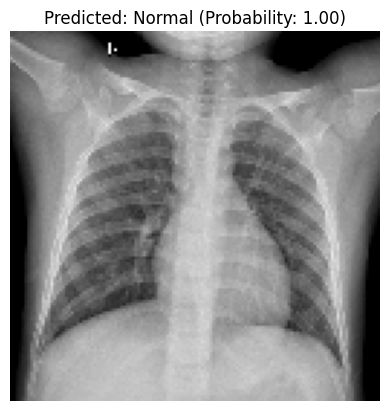

In [ ]:
def predict_image(image_path, model, img_size, categories):
  """Predicts the class of a single image.

  Args:
    image_path: Path to the image file.
    model: The loaded Keras model.
    img_size: Size to resize the image to.
    categories: List of possible categories/classes.

  Returns:
    A tuple containing:
      - The predicted class label (string).
      - The predicted class probability (float).
      - The image as a NumPy array.
  """
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)
  predicted_class_index = np.argmax(prediction)
  predicted_class_label = categories[predicted_class_index]
  predicted_class_probability = prediction[0][predicted_class_index]

  return predicted_class_label, predicted_class_probability, img_array


# Example usage:
image_path = '/content/drive/MyDrive/new_projects/N_p11/Pneumonia_Datasets/validation/Normal/Normal_img_021.jpeg'
predicted_label, probability, img_array = predict_image(image_path, loaded_model, img_size, categories)

# Display the image and prediction
plt.imshow(image.load_img(image_path, target_size=(img_size, img_size)))
plt.title(f"Predicted: {predicted_label} (Probability: {probability:.2f})")
plt.axis('off')
plt.show()
